In [4]:
# ! pip install Pillow
! pip install seaborn



In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [6]:
train_dir='C:\\Users\\annuy\\hand sign\\archive (3)\\Train'

In [7]:
for root, dirs, files in os.walk(train_dir):
    # print(root)
    print(dirs)
    print(files)


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
[]
[]
['10014_A.jpg', '10021_A.jpg', '10023_A.jpg', '10050_A.jpg', '10056_A.jpg', '10058_A.jpg', '10070_A.jpg', '10072_A.jpg', '10099_A.jpg', '10111_A.jpg', '10187_A.jpg', '10201_A.jpg', '10203_A.jpg', '10235_A.jpg', '10244_A.jpg', '10290_A.jpg', '10313_A.jpg', '10337_A.jpg', '10412_A.jpg', '10490_A.jpg', '10499_A.jpg', '10511_A.jpg', '10579_A.jpg', '10618_A.jpg', '10629_A.jpg', '10639_A.jpg', '10640_A.jpg', '10661_A.jpg', '1066_A.jpg', '10687_A.jpg', '10713_A.jpg', '10732_A.jpg', '10752_A.jpg', '10776_A.jpg', '10822_A.jpg', '10848_A.jpg', '10868_A.jpg', '1086_A.jpg', '10874_A.jpg', '10881_A.jpg', '10887_A.jpg', '10890_A.jpg', '10912_A.jpg', '10928_A.jpg', '10929_A.jpg', '11027_A.jpg', '11057_A.jpg', '11097_A.jpg', '11142_A.jpg', '11162_A.jpg', '11173_A.jpg', '11208_A.jpg', '11230_A.jpg', '1125_A.jpg', '11272_A.jpg', '11319_A.jpg', '11339_A.jpg', '11346_A.jpg', '1134

In [8]:
# # Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# # The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
# def count_files_in_subdirs(directory, set_name):
#     # Initialize an empty dictionary to hold the count of files for each subdirectory.
#     counts = {}

#     # Iterate over each item in the given directory.
#     for item in os.listdir(directory):
#         # Construct the full path to the item.
#         item_path = os.path.join(directory, item)

#         # Check if the item is a directory.
#         if os.path.isdir(item_path):
#             # Count the number of files in the subdirectory and add it to the dictionary.
#             counts[item] = len(os.listdir(item_path))

#     # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
#     # The index of the DataFrame is set to the provided set name.
#     df = pd.DataFrame(counts, index=[set_name])
#     return df

# # Paths to the training and testing directories.
# train_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train'
# test_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Test'

# # Count the files in the subdirectories of the training directory and print the result.
# train_count = count_files_in_subdirs(train_dir, 'train')
# print(train_count)

# # Count the files in the subdirectories of the testing directory and print the result.
# test_count = count_files_in_subdirs(test_dir, 'test')
# print(test_count)


In [9]:
# train_count.transpose().plot(kind='bar')

In [10]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)
        

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

In [11]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train'
test_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


          A     B     C     D    E     F     G     H     I     K  ...     P  \
train  1126  1010  1144  1196  957  1204  1090  1013  1162  1114  ...  1088   

          Q     R     S     T     U     V     W     X     Y  
train  1279  1294  1199  1186  1161  1082  1225  1164  1118  

[1 rows x 24 columns]
        A    B    C    D    E    F    G    H    I    K  ...    P    Q    R  \
test  331  432  310  245  498  247  348  436  288  331  ...  347  164  144   

        S    T    U    V    W    X    Y  
test  246  248  266  346  206  267  332  

[1 rows x 24 columns]


<Axes: >

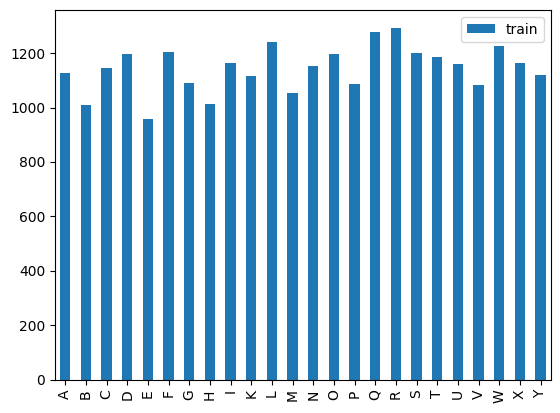

In [12]:
train_count.transpose().plot(kind='bar')

In [13]:
# hand_signs= os.listdir(train_dir)
# plt.figure(figsize=(15,10))

# for i, hand_sign in enumerate(hand_signs, 1):
#     folder = os.path.join(train_dir, hand_sign)
#     img_path = os.path.join(folder, os.listdir(folder)[42])
#     img = plt.imread(img_path)
#     plt.subplot(3, 4, i)
#     plt.imshow(img, cmap='gray')
#     plt.title(hand_sign)
#     plt.axis('off')

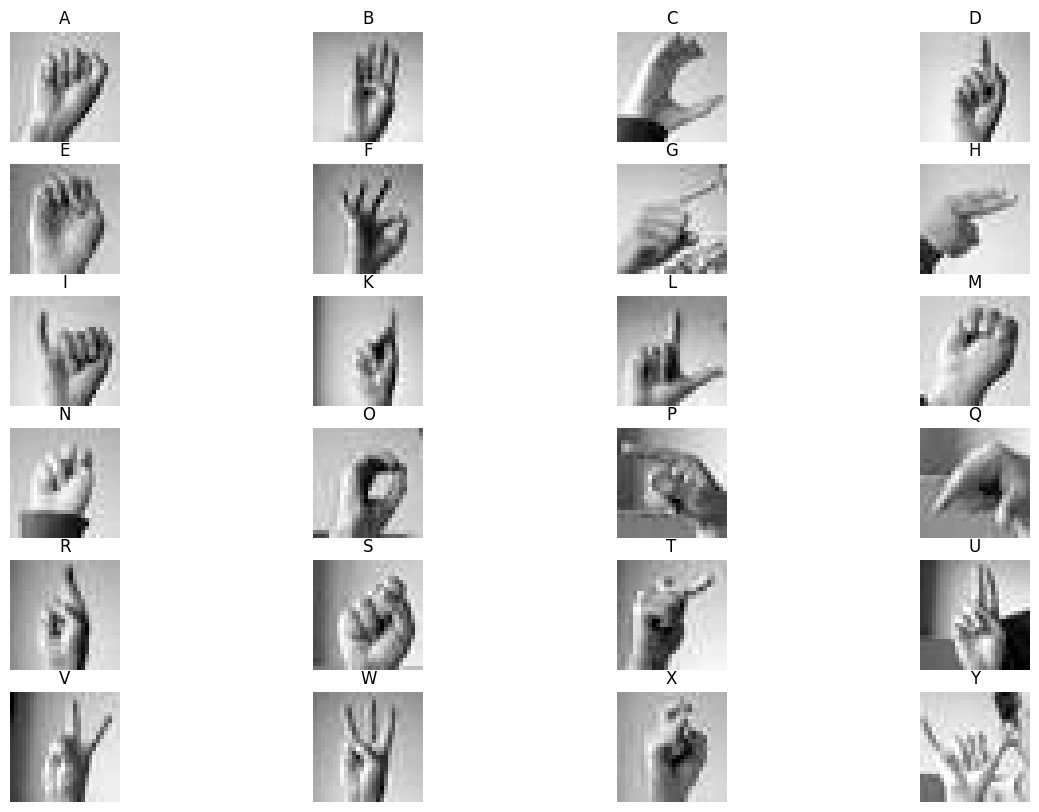

In [14]:
hand_signs = os.listdir(train_dir)
num_images = len(hand_signs)
num_cols = 4  # Set the number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows required

plt.figure(figsize=(15, 10))

# Loop through all hand signs and display them
for i, hand_sign in enumerate(hand_signs, 1):
    folder = os.path.join(train_dir, hand_sign)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(num_rows, num_cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(hand_sign)
    plt.axis('off')

plt.show()


In [15]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

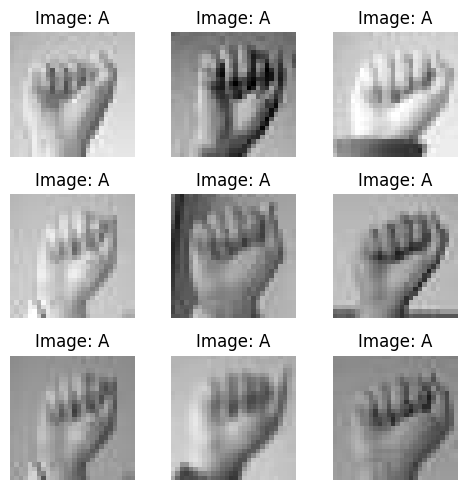

In [16]:
# Placeholder for the directory path
angry_directory_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train\\A'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'A')

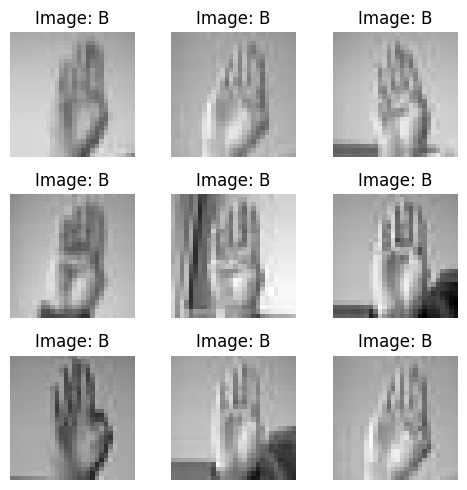

In [17]:
# Placeholder for the directory path
angry_directory_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train\\B'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'B')

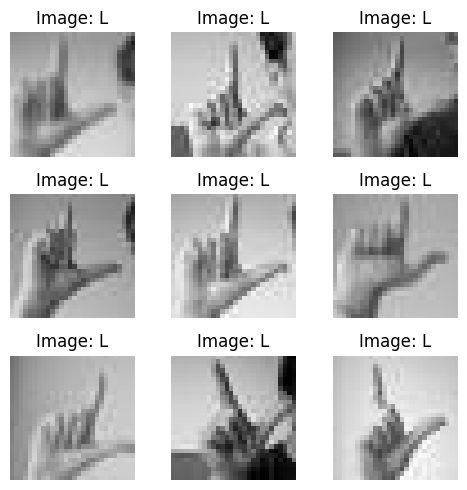

In [18]:
# Placeholder for the directory path
angry_directory_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train\\L'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'L')

In [19]:
image = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train\C\\2_C.jpg'
import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (28, 28, 3)


<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\annuy\AppData\Local\Temp\ipykernel_14476\3803166873.py:1: SyntaxWarning: invalid escape sequence '\C'
  image = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train\C\\2_C.jpg'


In [20]:
import cv2

image_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train\C\\2_C.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (28, 28)


<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
C:\Users\annuy\AppData\Local\Temp\ipykernel_14476\1109257900.py:3: SyntaxWarning: invalid escape sequence '\C'
  image_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train\C\\2_C.jpg'


In [21]:
# Define paths to the train and validation directories
train_data_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train'
test_data_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Test'

In [22]:
# Set some parameters
img_width, img_height = 28, 28  # Size of images
batch_size = 64
epochs = 10
num_classes = 24  # Update this based on the number of your classes

In [23]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 21974 images belonging to 24 classes.
Found 5481 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [24]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}
Validation class labels: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}
Validation class labels: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [25]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

c:\Users\annuy\anaconda3\envs\projectenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,675,352 (33.09 MB)

 Trainable params: 8,673,688 (33.09 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [27]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,675,352 (33.09 MB)

 Trainable params: 8,673,688 (33.09 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [29]:
! pip install pydot graphviz


  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached pydot-3.0.2-py3-none-any.whl (35 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


In [30]:
# plot_model(model, to_file = 'C:\\Users\\annuy\\hand sign\\archive (3)\\model_shape\\Architecture.png',
#            show_shapes=True, show_layer_names=True)

In [31]:
# File path for the model checkpoint
cnn_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\custom_cnn'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'C:\\Users\\annuy\\hand sign\\archive (3)\\custom_cnn\\Custom_CNN_model.keras'

In [32]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [33]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [34]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [35]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [36]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

In [37]:
train_generator.samples

21974

In [38]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
if train_generator.samples % train_generator.batch_size != 0:
    train_steps_per_epoch += 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
if validation_generator.samples % validation_generator.batch_size != 0:
    validation_steps_epoch += 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1
if test_generator.samples % test_generator.batch_size != 0:
    test_steps_epoch += 1

In [39]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10


c:\Users\annuy\anaconda3\envs\projectenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/345 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.3158 - loss: 13.6864

c:\Users\annuy\anaconda3\envs\projectenv\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 1: val_loss improved from inf to 13.94443, saving model to C:\Users\annuy\hand sign\archive (3)\custom_cnn\Custom_CNN_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 134s 363ms/step - accuracy: 0.3164 - loss: 13.6823 - val_accuracy: 0.1509 - val_loss: 13.9444 - learning_rate: 1.0000e-04
Epoch 2/10
344/345 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8506 - loss: 9.8908
Epoch 2: val_loss improved from 13.94443 to 8.38798, saving model to C:\Users\annuy\hand sign\archive (3)\custom_cnn\Custom_CNN_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 114s 332ms/step - accuracy: 0.8507 - loss: 9.8894 - val_accuracy: 0.9878 - val_loss: 8.3880 - learning_rate: 1.0000e-04
Epoch 3/10
344/345 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9598 - loss: 8.0586
Epoch 3: val_loss improved from 8.38798 to 6.82472, saving model to C:\Users\annuy\hand sign\archive (3)\custom_cnn\Custom_CNN_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 118s 341ms/step - accuracy: 0.9598 - loss: 8.0575 - val_accuracy: 0.9978 - val_

In [40]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

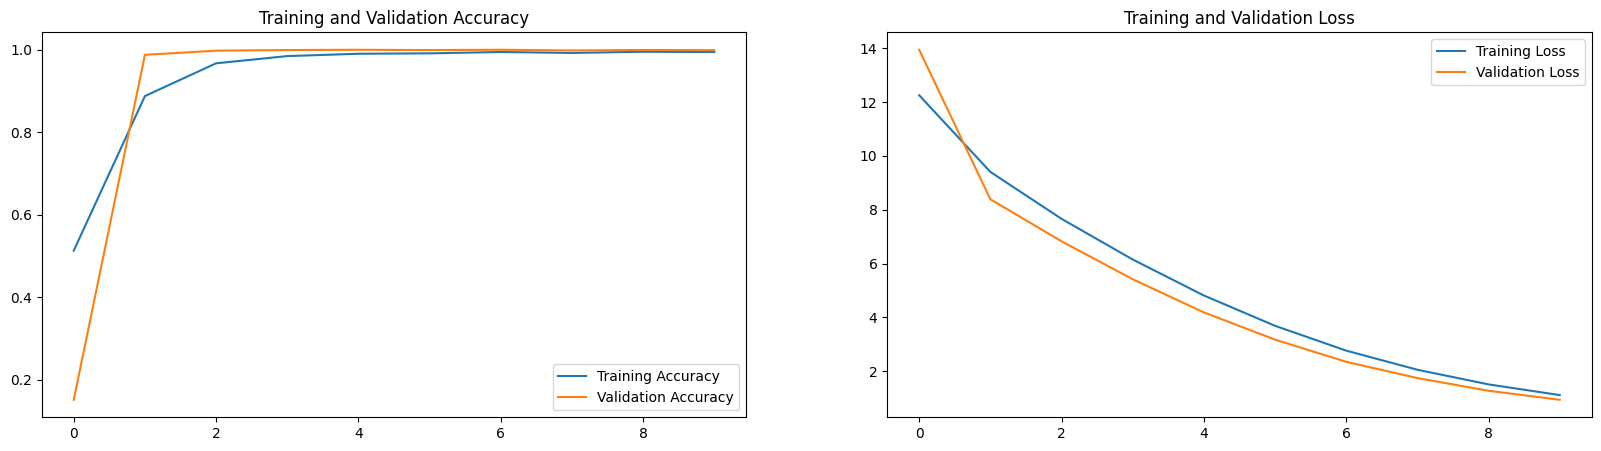

In [41]:
plot_training_history(history)

In [42]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

344/344 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9995 - loss: 0.9343
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.9655 - loss: 1.0210
final train accuracy = 99.93 , validation accuracy = 96.97


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step


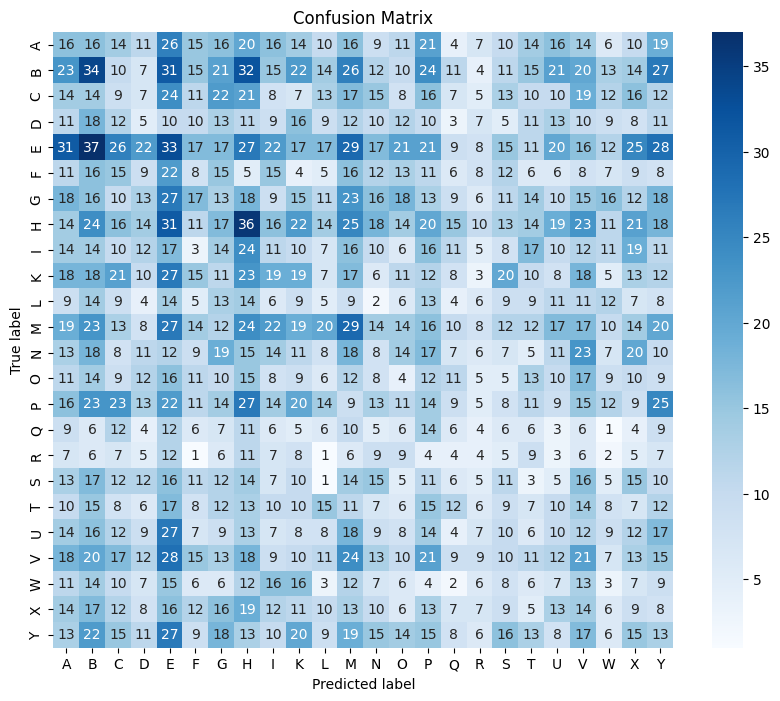

In [43]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           A       0.05      0.05      0.05       331
           B       0.08      0.08      0.08       432
           C       0.03      0.03      0.03       310
           D       0.02      0.02      0.02       245
           E       0.06      0.07      0.07       498
           F       0.03      0.03      0.03       247
           G       0.04      0.04      0.04       348
           H       0.08      0.08      0.08       436
           I       0.04      0.04      0.04       288
           K       0.06      0.06      0.06       331
           L       0.02      0.02      0.02       209
           M       0.07      0.07      0.07       394
           N       0.03      0.03      0.03       291
           O       0.02      0.02      0.02       246
           P       0.04      0.04      0.04       347
           Q       0.03      0.04      0.03       164
           R       0.03      0.03      0.03       144
   

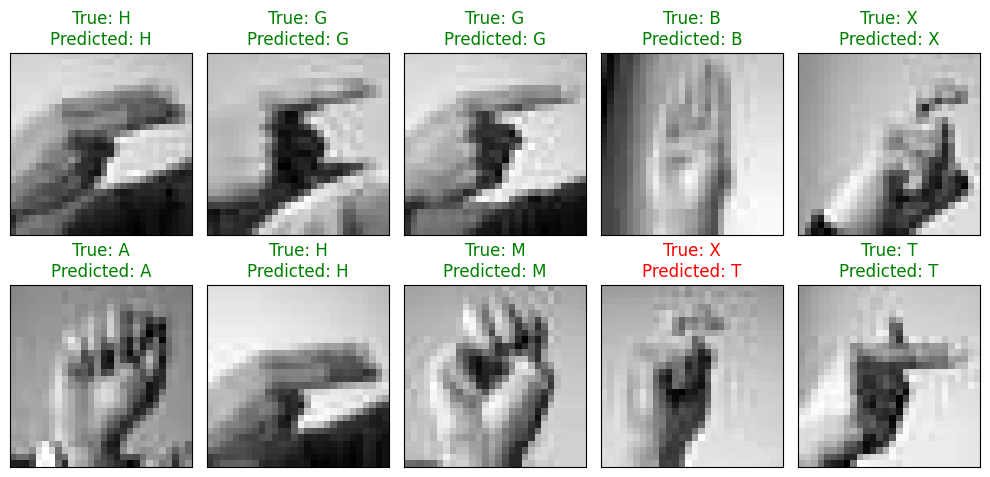

In [45]:
# Emotion classes for the dataset
Emotion_Classes = ['A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U','V', 'W', 'X', 'Y']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [46]:
# Define paths to the train and validation directories
train_data_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Train'
test_data_dir = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 21974 images belonging to 24 classes.
Found 5481 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


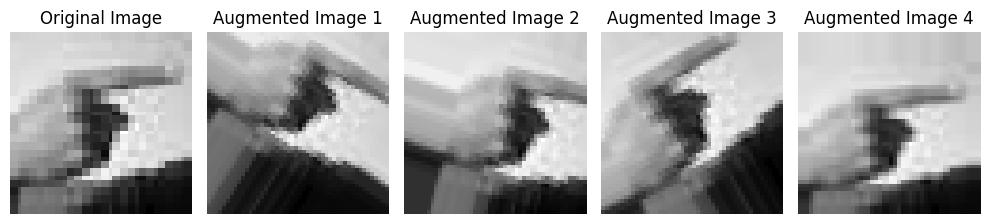

In [47]:
# Path to your specific image
image_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\Test\\G\\109_G.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [48]:
# # Assuming img_width, img_height, and classes are defined. For example:
# img_width, img_height = 48, 48
# classes = 24

# #Initialising the CNN
# model = tf.keras.models.Sequential()

# # Adding convolutional layers with activations on separate lines
# model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(2, 2))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # Flattening and adding dense layers
# model.add(Flatten())
# model.add(Dense(1024))
# model.add(tf.keras.layers.Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(classes))
# model.add(tf.keras.layers.Activation('softmax'))

# # Compiling the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


# # File path for the model checkpoint
# cnn_path = 'C:\\Users\\annuy\\hand sign\\archive (3)\\custom_cnn'
# name = 'Custom_CNN_model.keras'
# chk_path = os.path.join(cnn_path, name)

# # Callback to save the model checkpoint
# checkpoint = ModelCheckpoint(filepath=chk_path,
#                              save_best_only=True,
#                              verbose=1,
#                              mode='min',
#                              monitor='val_loss')

# # Callback for early stopping
# earlystop = EarlyStopping(monitor='val_loss',
#                           min_delta=0,
#                           patience=3,
#                           verbose=1,
#                           restore_best_weights=True)

# # Callback to reduce learning rate
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=6,
#                               verbose=1,
#                               min_delta=0.0001)

# # Callback to log training data to a CSV file
# csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# # Aggregating all callbacks into a list
# callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

# train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# if train_generator.samples % train_generator.batch_size != 0:
#     train_steps_per_epoch += 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
# if validation_generator.samples % validation_generator.batch_size != 0:
#     validation_steps_epoch += 1
# test_steps_epoch = test_generator.samples // test_generator.batch_size + 1
# if test_generator.samples % test_generator.batch_size != 0:
#     test_steps_epoch += 1

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_steps_per_epoch,
#     epochs=100,
#     validation_data=validation_generator,
#     validation_steps=validation_steps_epoch,
#     callbacks=callbacks)

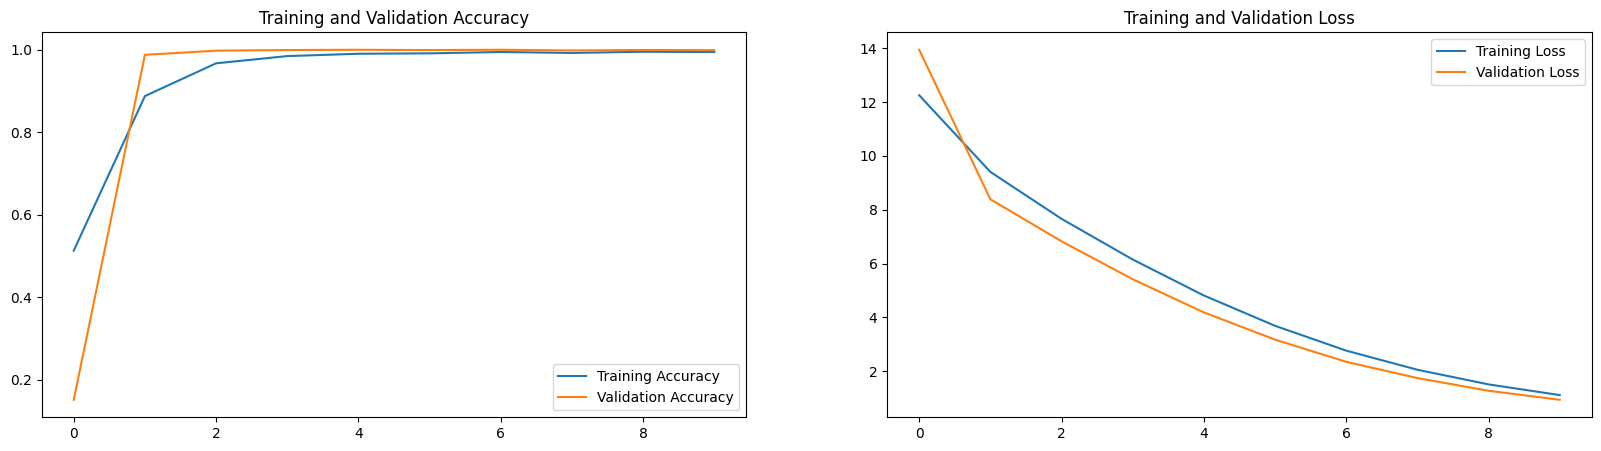

In [49]:
plot_training_history(history)